### Importing dependencies

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable

import time
import os
import copy

plt.ion()   # interactive mode

We will use torchvision and torch.utils.data packages for loading the data.


In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [7]:
batch_size = 128
img_size = 224
epochs = 3

In [8]:
traindir ='/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/train'
valdir = '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/validation'


### Create data generators

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train':
    transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.RandomResizedCrop(img_size,scale=(0.8,1),ratio=(1,1)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(10, shear=(0,10)),
            transforms.ToTensor(),
            normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        normalize
    ]),
}

data_dir = 'data_small'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'validation']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=256, shuffle=True, num_workers=4)
    for x in ['train', 'validation']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Import pre-trained ResNet50

In [13]:
model = models.resnet50(pretrained=True).to(device)

In [14]:
# Don't update non-classifier learned features in the pretrained networks
for param in model.parameters():
    param.requires_grad = False

### Stack trainable, fully-connected (dense) layers on top of it

In [15]:
# # Let's replace the last fully-connected layer with a tiny sequential model
# # Note that newly constructed modules are trainable (requires_grad=True) by default.

model.fc = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2),
        ).to(device)

# for layer in model.parameters():
#     print(layer.requires_grad)

### Prepare model checkpointing

In [16]:
def save_checkpoint(state, checkpoint):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    filepath = os.path.join(checkpoint, 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(checkpoint)
    else:
        print("Checkpoint Directory exists! ")
    torch.save(state, filepath)


In [23]:
def load_checkpoint(checkpoint, model, optimizer=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    if not os.path.exists(checkpoint):
        raise("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint

### Train the model


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.RMSprop(model.fc.parameters())

In [20]:
def train_model(model, criterion, optimizer, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # loss.item() gets the a scalar value held in the loss.

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                save_checkpoint({'epoch': epoch + 1,
                       'state_dict': model.state_dict(),
                       'optim_dict' : optimizer.state_dict()},
                       checkpoint='pytorch_models')

                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
%%time

model_conv = train_model(model, criterion, optimizer_conv,
                        num_epochs=epochs)

Epoch 0/2
----------
train Loss: 246.2616 Acc: 0.7355
validation Loss: 1.5602 Acc: 0.9760
Checkpoint Directory exists! 
Epoch 1/2
----------
train Loss: 2.5581 Acc: 0.9605
validation Loss: 1.6699 Acc: 0.9720
Epoch 2/2
----------
train Loss: 1.5304 Acc: 0.9680
validation Loss: 1.8430 Acc: 0.9680
Training complete in 0m 41s
Best val Acc: 0.976000
CPU times: user 18.7 s, sys: 8.96 s, total: 27.6 s
Wall time: 40.8 s


### Load the best model checkpoint and evaluate it on a sample image


In [24]:
state_dict = load_checkpoint('pytorch_models/last.pth.tar', model)['state_dict']

In [25]:
model = models.resnet50(pretrained=True).to(device)

# Don't update non-classifier learned features in the pretrained networks
for param in model.parameters():
    param.requires_grad = False

# # Let's replace the last fully-connected layer with a tiny sequential model
# # Note that newly constructed modules are trainable (requires_grad=True) by default.

model.fc = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2),
        ).to(device)

# for layer in model.parameters():
#     print(layer.requires_grad)

model.load_state_dict(state_dict)

In [45]:
test_cat = "/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/cats/cat.1505.jpg"

In [32]:
preprocess = transforms.Compose([
    transforms.Resize((img_size,img_size)),
       transforms.ToTensor(),

   normalize
])

In [33]:
img_pil = Image.open(test_cat)
img_tensor = preprocess(img_pil)
img_tensor.unsqueeze_(0)
img_variable = Variable(img_tensor).to(device)

model.eval()
fc_out = model(img_variable)

In [96]:
print(fc_out.cpu().data.numpy().argmax())

0


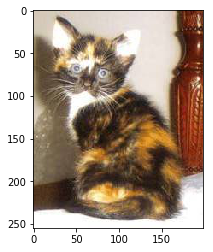

In [44]:
plt.imshow(img_pil)
plt.show()